# Sunrise Demo

## Setup

In [1]:
# %load init.py
#@title Import & Utilities
from __future__ import annotations

class AutoImportError(ImportError):
    pass

class auto(object):
    registry: ClassVar[Dict[str, Tuple[str, ...]]] = {}

    @classmethod
    def register(
        cls,
        import_name: str,
        package_name: Optional[str]=None,
        *extra_package_names: List[str],
    ):
        if package_name is None:
            package_name = import_name

        cls.registry[import_name] = (
            package_name,
            *extra_package_names,
        )

    def __getattr__(self, import_name: str):
        import subprocess, importlib, sys

        try:
            return object.__getattribute__(self, import_name)
        except AttributeError:
            pass

        module = None
        try:
            module = importlib.import_module(import_name)
        except ImportError as e:
            package_names = self.registry.get(import_name, [import_name])

            process = subprocess.run([
                sys.executable,
                '-m', 'pip',
                'install',
                *package_names,
            ], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

            if process.returncode != 0:
                raise AutoImportError(f"Failed to pip install {package_names!r}\n\n{process.stdout}") from e

            try:
                module = importlib.import_module(import_name)
            except ImportError as e:
                raise AutoImportError(f'Import failed a second time, even after a pip install') from e

        assert module is not None
        # print(f'setattr({self!r}, {import_name!r}, {module!r})')
        setattr(self, import_name, module)
        return module

auto.register('np', 'numpy')
auto.register('tqdm')
auto.register('more_itertools', 'more-itertools')
auto.register('torch')
auto.register('peft')
auto.register('guidance')
auto.register('langchain')
auto.register('diffusers')

auto.register('transformers', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('accelerate', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('datasets', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('tokenizers', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('evaluate', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')
auto.register('huggingface_hub', None, 'transformers', 'accelerate', 'datasets', 'tokenizers', 'evaluate', 'huggingface_hub', 'torch')

auto = auto()


def doctest(func=None, /, verbose=False, sterile=False):
    def wrapper(func):
        # Thanks https://stackoverflow.com/a/49659927
        import doctest, copy

        # I need this to error out on failure; the default one doesn't.
        def run_docstring_examples(f, globs, verbose=False, name="NoName", compileflags=None, optionflags=0):
            finder = doctest.DocTestFinder(verbose=verbose, recurse=False)
            runner = doctest.DocTestRunner(verbose=verbose, optionflags=optionflags)
            for test in finder.find(func, name, globs=globs):
                runner.run(test, compileflags=compileflags)
            assert runner.failures == 0

        name = func.__name__

        if sterile:
            globs = {}
        else:
            globs = copy.copy(globals())
        globs[name] = func
        run_docstring_examples(func, globs, verbose=verbose, name=name)
        return func

    if func is not None:
        return wrapper(func)
    else:
        return wrapper

try:
    g
except NameError:
    g = {}

try:
    f
except NameError:
    f = {}

def run(func=None, /, name=None, cond=True, splat=False, after=None, scope=None):
    def wrapper(func, /, *, name=name, cond=cond):
        import inspect

        if callable(cond):
            cond = cond()

        if not cond:
            return None

        if name is None:
            name = func.__name__
            
        f[name] = func

        args = []
        for key, parameter in inspect.signature(func).parameters.items():
            if parameter.kind == inspect.Parameter.POSITIONAL_ONLY:
                keys = [key]
                if scope is not None:
                    keys.insert(0, f'{scope}__{key}')
                
                for key in keys:
                    try:
                        value = g[key]
                    except KeyError:
                        continue
                    else:
                        args.append(value)
                        break
                else:
                    raise KeyError(f'None of {keys=!r} found in g')

        ret = func(*args)

        if callable(after):
            after(ret)

        if splat:
            it = ret.items()
        else:
            it = [(name, ret)]

        for name, ret in it:
            if scope is not None:
                name = f'{scope}__{name}'

            g[name] = ret

        return None

    if func is not None:
        return wrapper(func)
    else:
        return wrapper

@auto.IPython.core.magic.register_line_magic
@auto.IPython.core.magic.register_cell_magic
def source(magic_line, magic_cell=None):
    import os, subprocess, shlex

    if magic_cell is None or magic_cell == '':
        before = os.environ.copy()

        process = subprocess.run([
            'bash', '-c', f'source {magic_line}; export',
        ], capture_output=True, text=True)

        after = {}
        for line in process.stdout.split('\n'):
            if line == '': continue
            parts = shlex.split(line)
            assert parts[0] == 'declare', f'{line=!r}'
            assert parts[1] == '-x', f'{line=!r}'
            if '=' not in parts[2]: continue
            name, value = parts[2].split('=', 1)

            if before.get(name, None) == value: continue
            after[name] = value

        magic_cell = f'%%source {magic_line}\n'
        magic_cell += f'os.environ |= {{\n'
        for name, value in after.items():
            magic_cell += f'  {name!r}: '
            if ':' in value:
                magic_cell += f'":".join([\n'
                for value in value.split(':'):
                    magic_cell += f'    {value!r},\n'
                magic_cell += f'  ]),\n'
            else:
                magic_cell += f' {value!r},\n'
        magic_cell += f'}}\n'

        get_ipython().set_next_input(magic_cell, replace=True)

    get_ipython().run_cell(magic_cell)

In [2]:
def __numpy_string_function(arr):
    name = arr.__class__.__name__
    if arr.size < 1024:
        values = auto.numpy.array_repr(auto.numpy.ravel(arr))
    else:
        values = '...'
        
    shape = auto.numpy.shape(arr)
    dtype = arr.dtype
    return f'{name}({values}, {shape=!r}, {dtype=!r})'
auto.numpy.set_string_function(__numpy_string_function, repr=False)
auto.numpy.set_string_function(__numpy_string_function, repr=True)

auto.np.set_printoptions(
    threshold=4,
    edgeitems=0,
)

## Domain Modeling

### Typing

In [3]:
Degree = auto.typing.NewType('Degree', float)
Radian = auto.typing.NewType('Radian', float)
Meter = auto.typing.NewType('Meter', float)
Kilometer = auto.typing.NewType('Kilometer', float)

### Location (lat, lng, alt) to spatial (x, y, z)

In [4]:
def convert_location_to_spatial(
    *,
    lat: Degree,
    lng: Degree,
    alt: Meter,
    math=auto.math,
) -> Tuple[Meter, Meter, Meter]:
    # Thanks https://gis.stackexchange.com/a/4148
    
    #> Note that "Lat/Lon/Alt" is just another name for spherical coordinates, and 
    #> phi/theta/rho are just another name for latitude, longitude, and altitude.
    #> :) (A minor difference: altitude is usually measured from the surface of the 
    #> sphere; rho is measured from the center -- to convert, just add/subtract the 
    #> radius of the sphere.)
    phi: Radian = math.radians(lat)
    theta: Radian = math.radians(lng)
    
    # Thanks https://en.wikipedia.org/wiki/Earth_radius
    #> A globally-average value is usually considered to be 6,371 kilometres (3,959 mi)
    rho: Meter = 6_371_000 + alt
    
    #> x = math.cos(phi) * math.cos(theta) * rho
    x: Meter = math.cos(phi) * math.cos(theta) * rho
    
    #> y = math.cos(phi) * math.sin(theta) * rho
    y: Meter = math.cos(phi) * math.sin(theta) * rho

    #> z = math.sin(phi) * rho # z is 'up'
    z: Meter = math.sin(phi) * rho
    
    #> (Note there's some slightly arbitrary choices here in what each axis means...
    #> you might want 'y' to point at the north pole instead of 'z', for example.)
    
    # I do :)
    y, z = z, y
    
    return x, y, z

### Tile (zoom, x, y) to location (lat, lng)

In [5]:
@doctest
def convert_tile_coordinates_to_latlng(
    *,
    z: int,
    x: int,
    y: int,
    math=auto.numpy,
    return_google_maps_url: bool=False,
) -> Tuple[Degree, Degree]:
    r"""

    >>> convert_tile_coordinates_to_latlng(z=15, x=8739, y=12925, return_google_maps_url=True)
    'https://www.google.com/maps/@35.48751102385376,-83.990478515625,15.79z?entry=ttu'

    """
    
    # Thanks https://gis.stackexchange.com/a/133535
    
    #> n = 2 ^ zoom
    n = 2 ** z
    
    #> lon_deg = xtile / n * 360.0 - 180.0
    lon_deg = x / n * 360.0 - 180.0
    
    #> lat_rad = arctan(sinh(π * (1 - 2 * ytile / n)))
    lat_rad = math.arctan(math.sinh(math.pi * (1.0 - 2.0 * y / n)))
    
    #> lat_deg = lat_rad * 180.0 / π
    lat_deg = lat_rad * 180.0 / math.pi
    
    if return_google_maps_url:
        return f"""https://www.google.com/maps/@{lat_deg},{lon_deg},15.79z?entry=ttu"""
    
    return lat_deg, lon_deg

### Dataclasses

In [6]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Coord:
    """Tile image coordinates for mapbox/etc services"""
    z: int
    x: int
    y: int

    @property
    def nw(self) -> Location:
        """North-West lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=self.x,
            y=self.y,
        )
        return Location(lat=lat, lng=lng)

    @property
    def se(self) -> Location:
        """South-East lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=1+self.x,
            y=1+self.y,
        )
        return Location(lat=lat, lng=lng)

@auto.dataclasses.dataclass(eq=True, frozen=True)
class Domain:
    """Lower (inclusive) and upper (inclusive) bounds of latitude/longitude"""
    lo: Coord
    hi: Coord
        
    @property
    def coords(self) -> List[Coord]:
        """All coordinates within lower/upper bounds"""
        coords = []
        for z, x, y in auto.itertools.product(
            range(self.lo.z, 1+self.hi.z),
            range(self.lo.x, 1+self.hi.x),
            range(self.lo.y, 1+self.hi.y),
        ):
            coords.append(Coord(
                z=z,
                x=x,
                y=y,
            ))
        
        return coords

@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Location:
    """Geographical latitude/longitude"""
    lat: Degree
    lng: Degree
    alt: Optional[Meter] = auto.dataclasses.field(default=None)

@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Point:
    x: Kilometer
    y: Kilometer
    z: Kilometer

In [7]:
def dispatch(func, /):
    dispatch = auto.functools.singledispatch(func)
    
    @auto.functools.wraps(func)
    def wrapper(*args, **kwargs):
        if not args:
            return func(**kwargs)
        
        return dispatch(*args, **kwargs)
    
    wrapper.register = dispatch.register
    wrapper.dispatch = dispatch.dispatch
    wrapper.registry = dispatch.registry
    wrapper._clear_cache = dispatch._clear_cache
    return wrapper

# @dispatch
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Tixel:
    y: int
    x: int
        
    z: ClassVar[int] = 23
        
    @property
    def location(self) -> Location:
        """Center lat/lng of current tixel"""
        lat, lng = tile_coordinates_to_latlng(
            z=1+self.z,
            x=1+self.x,
            y=1+self.y,
        )
        return Location(lat=lat, lng=lng)

# @Tixel.register
# def __tixel_from_coord(coord: Coord, /, *, res: int):
#     dz = int(auto.math.log2(Tixel.z - coord.z))
    
    

### URL

In [8]:
@auto.dataclasses.dataclass
class TileURL:
    scheme: str
    netloc: str
    prefix: str
    z: int
    x: int
    y: int
    suffix: str
    query: Dict[str, str]
    fragment: str

    @classmethod
    @doctest
    def decode(cls, url: str) -> Self:
        r"""
        
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov',
         'prefix': ['', 'styles', 'v1', 'atlas-user', 'ck58pyquo009v01p99xebegr9', 'tiles', '256'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '@2x',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov:443',
         'prefix': ['', 'v4', 'atlas-user.0000214_pink'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '.png',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        
        """
        
        scheme, netloc, path, query, fragment = auto.urllib.parse.urlsplit(
            url,
        )
        path = path.split('/')
        *prefix, z, x, suffix = path
        assert (match := auto.re.match(r'^(\d+)(.*)$', suffix)) is not None, \
            f'{suffix = !r}'
        y, suffix = match.groups()
            
        
        z, x, y = map(int, (z, x, y))
        query = auto.urllib.parse.parse_qsl(
            query,
        )

        return cls(
            scheme=scheme,
            netloc=netloc,
            prefix=prefix,
            z=z,
            x=x,
            y=y,
            suffix=suffix,
            query=query,
            fragment=fragment,
        )

    def encode(self) -> str:
        query = auto.urllib.parse.urlencode(
            self.query,
            doseq=True,
        )
        
        z, x, y = map(str, (self.z, self.x, self.y))

        path = '/'.join([
            *self.prefix,
            z,
            x,
            y + self.suffix,
        ])

        return auto.urllib.parse.urlunsplit((
            self.scheme,
            self.netloc,
            path,
            query,
            self.fragment,
        ))
    

## HTTP Request Caching

In [9]:
@run(cond='cache' not in g)
def cache():
    return {}

@run
def cache(cache, /):
    def load() -> Dict:
        ret = {}
        try:
            with open(path, 'rb') as f:
                ret = auto.pickle.load(f)
                print(f'Read {f.tell():,d} bytes from {path}')
        except Exception as e:
            print('load failed:')
            auto.traceback.print_exception(e)
        
        return ret
    
    def merge(mutable: Dict, constant: Dict):
        try:
            for k, v in constant.items():
                if k in mutable:
                    continue

                mutable[k] = v
        except Exception as e:
            print('merge failed:')
            auto.traceback.print_exception(e)
    
    def dump(d: Dict):
        try:
            with open(path, 'wb') as f:
                auto.pickle.dump(d, f)

                print(f'Wrote {f.tell():,d} bytes to {path}')
        except Exception as e:
            print('dump failed:')
            auto.traceback.print_exception(e)
        
    path = auto.pathlib.Path.cwd() / 'tmp' / 'Sunrise Demo Cache.pickle'
    
    if path.exists():
        merge(cache, load())
    
    dump(cache)
    
    return cache

Read 18,018,813 bytes from /home/thobson2/src/Sunrise-Demo/tmp/Sunrise Demo Cache.pickle
Wrote 18,018,813 bytes to /home/thobson2/src/Sunrise-Demo/tmp/Sunrise Demo Cache.pickle


In [12]:
@run
def fetch(cache, /):
    def fetch(url: str, *, tqdm=None) -> bytes:
        key = url
        if key not in cache:
            if tqdm is not None:
                tqdm.set_description(f'Cache Miss: {url}')

            with auto.requests.get(url) as r:
                r.raise_for_status()
                cache[key] = r.content
            
            auto.time.sleep(1)
        
        else:
            if tqdm is not None:
                tqdm.set_description('Cache Hit: {url}')
        
        return cache[key]

    return fetch

## Observations

In [13]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Observation:
    common_name: str
    irma_id: str
    latin_name_ref: str
    latin_name: str

@run
def observations(fetch, /):
    observations = []
    for observation in (
        Observation(**kwargs)
        for kwargs in (
            auto.json.loads(fetch('https://species.atlasofthesmokies.org/atbirecords/lexical_index.json'))
        )['items']
    ):
        observations.append(observation)
    
    return observations

In [14]:
@run(after=print)
def observation(observations, /):
    for observation in observations:
        if observation.common_name not in [
            'Alternate-Leaf Dogwood',
#             'A Spiny Crawler Mayfly',
#             'Acadian Flycatcher',
#             'Agreeable Tiger Moth',
        ]:
            continue
        
        return observation

Observation(common_name='Alternate-Leaf Dogwood', irma_id='0010099', latin_name_ref='Cornus alternifolia', latin_name='Cornus_alternifolia')


In [15]:
def contextgenerator(func=None, /, *, call=lambda generator: generator):
    if func is None:
        return auto.functools.partial(contextgenerator, call=call)
    
    @auto.contextlib.contextmanager
    @auto.functools.wraps(func)
    def wrapper(*args, **kwargs):
        generator = None
        try:
            generator = func(*args, **kwargs)
            
            next(generator)
            yield call(generator)
        
        finally:
            if generator is not None:
                generator.close()
        
    return wrapper

In [16]:
@run(scope='observation')
def db(observation, /):
    @contextgenerator(call=lambda generator: lambda sql, /, **parameters: generator.send((sql, parameters)))
    def db(observation: Observation=observation, /):
        root = auto.pathlib.Path('/mnt/seenas2/data/johns_nps_run/maxent/mbtiles/out')
        path = root / f'atlas-user.{observation.irma_id}_pink.mbtiles'
        
        with auto.sqlite3.connect(path) as db:
            db.row_factory = auto.sqlite3.Row
            
            cursor = None
            while True:
                sql, parameters = yield cursor
                cursor = db.execute(sql, parameters)
    
    return db

@run(scope='observation', after=print)
def z():
    z = 15
    return z

@auto.dataclasses.dataclass(eq=True, frozen=True)
class ObservationTile:
    z: int
    y: int
    x: int
    image: bytes = auto.dataclasses.field(repr=False)

@run(scope='observation')
def tiles(db, z, /):
    with db() as db:
        tiles = []
        for tile in db(r'''
            SELECT
                tile_row AS y_tms,
                tile_column AS x,
                zoom_level AS z,
                tile_data AS image
            FROM tiles
            WHERE zoom_level = :z
        ''', z=z):
            tiles.append(ObservationTile(
                z=tile['z'],
                y=2 ** tile['z'] - 1 - tile['y_tms'],
                x=tile['x'],
                image=tile['image'],
            ))
    
    return tiles

@run(scope='observation', after=print)
def xs(tiles, /):
    return sorted(set(tile.x for tile in tiles))

@run(scope='observation', after=print)
def ys(tiles, /):
    return sorted(set(tile.y for tile in tiles))

15
[8738, 8739, 8740, 8741, 8742, 8743, 8744, 8745, 8746, 8747, 8748, 8749, 8750, 8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760, 8761, 8762, 8763, 8764, 8765, 8766, 8767, 8768, 8769, 8770, 8771, 8772, 8773, 8774, 8775, 8776, 8777, 8778, 8779, 8780, 8781, 8782, 8783, 8784, 8785, 8786, 8787, 8788, 8789, 8790, 8791, 8792, 8793, 8794, 8795, 8796, 8797, 8798, 8799, 8800, 8801, 8802, 8803, 8804, 8805, 8806, 8807, 8808, 8809, 8810, 8811, 8812, 8813, 8814, 8815, 8816, 8817, 8818, 8819, 8820, 8821, 8822, 8823, 8824, 8825]
[12890, 12891, 12892, 12893, 12894, 12895, 12896, 12897, 12898, 12899, 12900, 12901, 12902, 12903, 12904, 12905, 12906, 12907, 12908, 12909, 12910, 12911, 12912, 12913, 12914, 12915, 12916, 12917, 12918, 12919, 12920, 12921, 12922, 12923, 12924, 12925, 12926, 12927, 12928, 12929, 12930, 12931]


In [17]:
# @run(scope='observation')
# def __estimate_data_sizes(z, xs, ys, /):
#     found = []
    
#     missing_x = auto.collections.Counter()
#     missing_y = auto.collections.Counter()
#     with db() as db:
#         for x, y in auto.itertools.product(xs, ys):
#             (exists,) ,= db(r'''
#                 SELECT EXISTS(SELECT 1 FROM tiles WHERE zoom_level = :z AND tile_column = :x AND tile_row = :y)
#             ''', z=z, x=x, y=y)
            
#             if not exists:
#                 missing_x[x] += 1
#                 missing_y[y] += 1
                
#                 continue
            
#             (length,) ,= db(r'''
#                 SELECT LENGTH(tile_data) FROM tiles WHERE zoom_level = :z AND tile_column = :x AND tile_row = :y
#             ''', z=z, x=x, y=y)
                
#             found.append((z, x, y, length))
    
#     auto.pprint.pprint(missing_x.most_common())
#     auto.pprint.pprint(missing_y.most_common())
    
#     res = 256

#     print(f"""\
# Out of {len(xs)*len(ys)} possible tiles:
#   {len(found)} tiles exist
#   {len(xs)*len(ys)-len(found)} tiles do not exist
#   {sum(f[3] for f in found):,d} total bytes of PNG data
# """)
                
# #     assert len(found) == len(xs)*len(ys), \
# #         f"""Expected no missing tiles: missing {len(xs)*len(ys)-len(missing)}/{len(xs)*len(ys)} tiles"""

#     print(f"""\
# An array of shape={(len(ys), len(xs), res, res, 1)} dtype=uint8:
#   equivalent to shape={(len(ys)*res, len(xs)*res, 1)} dtype=uint8
#   {len(ys)*len(xs)*res*res*1*1:,d} total bytes
# """)
    
#     print(f"""\
# The resulting tile coordinates will be:
#   from z={z+int(auto.math.log2(res))} x={min(xs)*res} y={min(ys)*res}
#   to z={z+int(auto.math.log2(res))} x={max(xs)*res+res-1} y={max(ys)*res+res-1}
  
# """)

In [18]:
@run(scope='observation')
def interpolator(tiles, z, xs, ys, /):
    res = 256
    
    # Thanks https://species.atlasofthesmokies.org/style.css
    pinks = auto.numpy.array([
        # Black, obviously.
        # Represents 0-25%
        [0, 0, 0],

        #> #legend-pink-50 { background-color: #f069a3; }
        # Represents 25-50%
        [247, 105, 164],

        #> #legend-pink-75 { background-color: #c31d8e; }
        # Represents 50-75%
        [196, 28, 142],

        #> #legend-pink-100 { background-color: #752879; }
        # Represents 75-100%
        [121, 0, 124],
    ], dtype=auto.numpy.uint8)
        
    @contextgenerator(call=lambda gen: lambda *, z, x, y: gen.send((z, x, y)))
    def category() -> Generator[Optional[auto.numpy.ndarray], tuple[float, float, float], None]:
        category = None
        while True:
            z, x, y = yield category
            
            for tile in tiles:
                if tile.z == z and tile.x == x and tile.y == y:
                    break
            
            else:
                category = None
                continue

#             (exists,) ,= db(r'''
#                 SELECT EXISTS(SELECT 1 FROM tiles WHERE zoom_level = :z AND tile_column = :x AND tile_row = :y)
#             ''', z=z, x=x, y=y)

#             if not exists:
#                 category = None
#                 continue

#             (image,) ,= db(r'''
#                 SELECT tile_data FROM tiles WHERE zoom_level = :z AND tile_column = :x AND tile_row = :y
#             ''', z=z, x=x, y=y)

            with auto.io.BytesIO(tile.image) as f:
                image = auto.PIL.Image.open(f)
                image.load()

            rgb = image.convert('RGB')
            rgb = auto.numpy.array(rgb)

            assert rgb.shape == (res, res, 3), \
                f"""Wrong shape for observation tile image: {rgb.shape=!r}"""

            rgb = rgb.reshape((res*res, 3))

            diffs = auto.numpy.subtract(rgb[:, None, :], pinks[None, :, :], dtype=auto.numpy.float32)
            assert diffs.shape == (res*res, len(pinks), 3)

            dists = auto.numpy.linalg.norm(diffs, axis=-1)
            assert dists.shape == (res*res, len(pinks))

            category = auto.numpy.argmin(dists, axis=-1)
            assert category.shape == (res*res)

            category = category.astype(auto.numpy.uint8)
            category = category.reshape((res, res))
    
    dz = int(auto.math.log2(res))
    points = (
        auto.numpy.arange(
            (min(ys) + 0) * 2 ** dz,
            (max(ys) + 1) * 2 ** dz,
        ),
        auto.numpy.arange(
            (min(xs) + 0) * 2 ** dz,
            (max(xs) + 1) * 2 ** dz,
        ),
    )
    z += dz
    
    assert z == Tixel.z
    
    values = auto.numpy.zeros(
        shape=(
            len(ys)*res,
            len(xs)*res,
        ),
        dtype=auto.numpy.uint8,
    )
    
    with category() as category:
        for (yi, y), (xi, x) in auto.tqdm.tqdm(auto.itertools.product(
            enumerate(ys),
            enumerate(xs),
        ), total=len(ys)*len(xs)):
            src = category(
                z=z,
                x=x,
                y=y,
            )

            if src is None:
                continue
                
            values[
                slice(
                    (yi + 0) * res,
                    (yi + 1) * res,
                ),
                slice(
                    (xi + 0) * res,
                    (xi + 1) * res,
                ),
            ] = src
    
    return auto.scipy.interpolate.RegularGridInterpolator(
        points=points,
        values=values,
        method='nearest',
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3696/3696 [00:00<00:00, 7606.50it/s]


In [19]:
g['observation__interpolator'].grid[0][[0, -1]]

ndarray(array([3299840., 3310591.]), shape=(2,), dtype=dtype('float64'))

## Background

In [20]:
@run(after=auto.pprint.pp, scope='background')
def domain():
    from bs4 import BeautifulSoup
    
    soup = BeautifulSoup(r'''
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;">
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -275px, 0px); opacity: 1;">
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 493px, 0px); opacity: 1;">
    ''', 'html.parser')
    
    urls = []
    for img in soup('img'):
        src = img['src']
        url = TileURL.decode(src)
        urls.append(url)
    
    return Domain(
        lo=Coord(
            z=min(url.z for url in urls),
            x=min(url.x for url in urls),
            y=min(url.y for url in urls),
        ),
        hi=Coord(
            z=max(url.z for url in urls),
            x=max(url.x for url in urls),
            y=max(url.y for url in urls),
        ),
    )

Domain(lo=Coord(z=11, x=546, y=805), hi=Coord(z=11, x=551, y=808))


In [21]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Tile:
    coord: Coord
    url: str = auto.dataclasses.field(repr=False)
    image: bytes = auto.dataclasses.field(repr=False)

@run(scope='background', after=lambda x: print(len(x)))
def tiles(domain, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        r"""https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg"""
    )):
        return auto.dataclasses.replace(
            url,
            z=coord.z,
            x=coord.x,
            y=coord.y,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        image = fetch(url, tqdm=tqdm)

        tiles.append(Tile(
            coord=coord,
            url=url,
            image=image,
        ))

    return tiles

Cache Hit: {url}: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 857.71it/s]

24


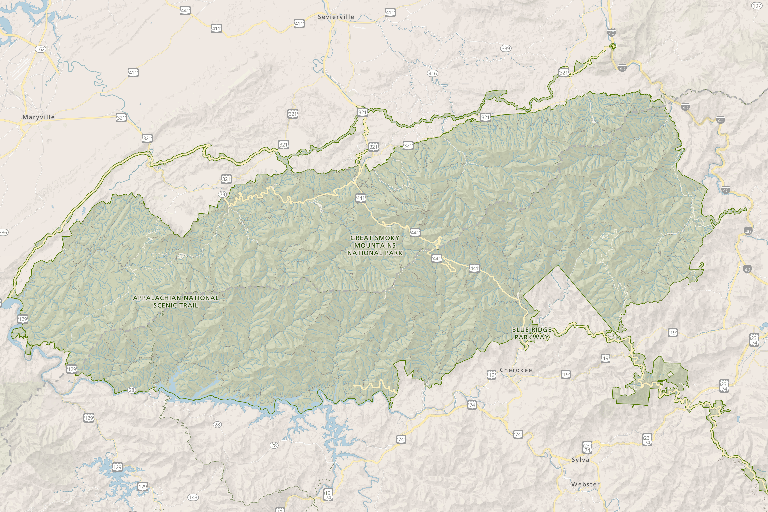

In [22]:
auto.register('PIL', 'Pillow')

@run(scope='background', after=auto.IPython.display.display)
def __stitch_tiles(tiles, /):
    auto.PIL; from PIL import Image
    
    xs = set(tile.coord.x for tile in tiles)
    ys = set(tile.coord.y for tile in tiles)
    
    xs = sorted(xs)
    ys = sorted(ys)
    
    nx = len(xs)
    ny = len(ys)
    
    sz = 128
    
    composite = Image.new('RGB', (nx*sz, ny*sz))
    
    for tile in tiles:
        xi = xs.index(tile.coord.x)
        yi = ys.index(tile.coord.y)
        
        with auto.io.BytesIO(tile.image) as f:
            try:
                image = Image.open(f)
            except auto.PIL.UnidentifiedImageError:
                continue

            image.thumbnail((sz, sz))

        composite.paste(image, (xi*sz, yi*sz))
    
    return composite

## Elevation

In [23]:
@run(scope='elevation', after=print)
def domain():
    return Domain(
        lo=Coord(z=11, x=546-1, y=805-1),
        hi=Coord(z=11, x=551+1, y=808+1),
    )

@run(scope='elevation')
def tiles(domain, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        r"""https://api.mapbox.com/v4/mapbox.terrain-rgb/14/3826/6127@2x.pngraw?access_token=pk.eyJ1IjoidGhvYnNvbjIiLCJhIjoiY2oxZmdqbnQzMDBpbjJxczR6dWoyemUxNiJ9.SEBHSdHLP_lZGD43r-_IDQ"""
    )) -> URL:
        return auto.dataclasses.replace(
            url,
            z=coord.z,
            x=coord.x,
            y=coord.y,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        image = fetch(url, tqdm=tqdm)
        
        tiles.append(Tile(
            coord=coord,
            url=url,
            image=image,
        ))
    
    return tiles

Domain(lo=Coord(z=11, x=545, y=804), hi=Coord(z=11, x=552, y=809))


Cache Miss: https://api.mapbox.com/v4/mapbox.terrain-rgb/11/552/809@2x.pngraw?access_token=pk.eyJ1IjoidGhvYnNvbjIiLCJhIjoiY2oxZmdqbnQzMDBpbjJxczR6d


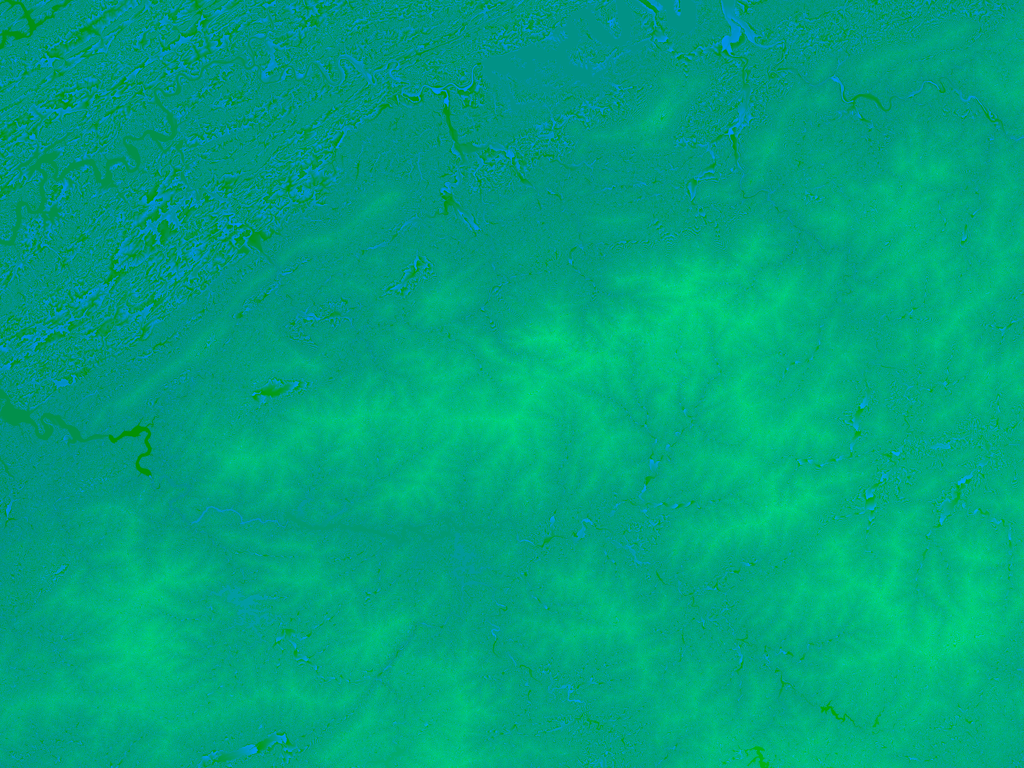

In [24]:
f['__stitch_tiles'](g['elevation__tiles'])

In [25]:
@run(scope='elevation')
def interpolator(tiles, /):
    res = 512
    
    def tile_altitude(tile: Tile, /) -> auto.numpy.NDArray[auto.numpy.float32]:
        with auto.io.BytesIO(tile.image) as f:
            image = auto.PIL.Image.open(f)
            image.load()
        
        image = image.convert('RGB')
        
        rgb = auto.numpy.array(image)
        assert len(rgb.shape) == 3, \
            f"""Expected dimension 3: {rgb.shape=!r}"""
        assert rgb.shape[0] == rgb.shape[1], \
            f"""Expected square image: {rgb.shape=!r}"""
        assert rgb.shape[0] == res, \
            f"""Expected resolution: {res}; Got resolution: {rgb.shape[0]}"""
        assert rgb.shape[2] == 3, \
            f"""Expected last component to be rgb values: {rgb.shape=!r}"""
        assert rgb.dtype == auto.numpy.uint8, \
            f"""Expected dtype to be uint8_t: {rgb.dtype=!r}"""
        
        # Thanks https://docs.mapbox.com/data/tilesets/guides/access-elevation-data/#decode-data
        #> elevation = -10000 + (({R} * 256 * 256 + {G} * 256 + {B}) * 0.1)
        
        altitude = auto.numpy.zeros(
            shape=(rgb.shape[0], rgb.shape[1]),
            dtype=auto.numpy.float32,
        )
        
        altitude += rgb[:, :, 0] * (1 * 256 * 256)
        altitude += rgb[:, :, 1] * (1 * 256)
        altitude += rgb[:, :, 2] * (1)
        altitude *= 0.1
        altitude -= 10000
        
        return altitude

    xs = sorted(set(tile.coord.x for tile in tiles))
    ys = sorted(set(tile.coord.y for tile in tiles))
    zs = sorted(set(tile.coord.z for tile in tiles))
    
    assert len(zs) == 1
    z ,= zs
    
    print(f'{z=!r}')
    
    dz = int(auto.math.log2(res))
    print(f'{dz=!r} {res=!r}')
    points = (
        auto.numpy.arange(
            (min(ys) + 0) * 2 ** dz,
            (max(ys) + 1) * 2 ** dz,
        ),
        auto.numpy.arange(
            (min(xs) + 0) * 2 ** dz,
            (max(xs) + 1) * 2 ** dz,
        ),
    )
    z += dz
    print(f'{z=!r}')
    
    print(f'{points[0][0]=!r}')
    print(f'{points[0][-1]=!r}')
    
    if z < Tixel.z:
        dz = Tixel.z - z
        print(f'{dz=!r}')
        points = (
            points[0] * 2 ** dz,
            points[1] * 2 ** dz,
        )
        z += dz
        print(f'{z=!r}')
        
        print(f'{points[0][0]=!r}')
        print(f'{points[0][-1]=!r}')
    
    assert z == Tixel.z
    
    values = auto.numpy.zeros(
        shape=(
            len(ys)*res,
            len(xs)*res,
        ),
        dtype=auto.numpy.float32,
    )
    
    for tile in tiles:
        xi = xs.index(tile.coord.x)
        yi = ys.index(tile.coord.y)
        
        values[
            slice(
                (yi + 0) * res,
                (yi + 1) * res,
            ),
            slice(
                (xi + 0) * res,
                (xi + 1) * res,
            ),
        ] = tile_altitude(tile)

    return auto.scipy.interpolate.RegularGridInterpolator(
        points=points,
        values=values,
    )

z=11
dz=9 res=512
z=20
points[0][0]=411648
points[0][-1]=414719
dz=3
z=23
points[0][0]=3293184
points[0][-1]=3317752


In [26]:
g['elevation__interpolator']([
    g['elevation__interpolator'].grid[0][100],
    g['elevation__interpolator'].grid[1][100],
], method='quintic')

ndarray(array([256.9004], dtype=float32), shape=(1,), dtype=dtype('float32'))

## OSPRay

In [59]:
@run
def __generate_mesh(elevation__interpolator, observation__interpolator, /):
    # Thanks https://species.atlasofthesmokies.org/style.css
    pinks = auto.numpy.array([
        # Black, obviously.
        # Represents 0-25%
        [0, 0, 0],

        #> #legend-pink-50 { background-color: #f069a3; }
        # Represents 25-50%
        [247, 105, 164],

        #> #legend-pink-75 { background-color: #c31d8e; }
        # Represents 50-75%
        [196, 28, 142],

        #> #legend-pink-100 { background-color: #752879; }
        # Represents 75-100%
        [121, 0, 124],
    ], dtype=auto.numpy.uint8)
        
    root = auto.pathlib.Path.home() / 'src' / 'Sunrise-Demo' / 'data'
    root.mkdir(parents=True, exist_ok=True)
    
    with auto.contextlib.ExitStack() as stack:
        @auto.contextlib.contextmanager
        def open(path, mode, /):
            fileobj = None
            try:
                fileobj = auto.builtins.open(path, mode)
                yield fileobj
            finally:
                try:
                    print(f'Wrote {fileobj.tell():,d} bytes to {path}')
                except:
                    pass
            
        def emit(name, format, /, *values, cache={}):
            try:
                fileobj = cache[name]
            except KeyError:
                fileobj = cache[name] = stack.enter_context(open(root / name, 'wb'))
            
            for v in values:
                if isinstance(v, auto.numpy.ndarray):
                    assert v.shape == (), \
                        f"""Wrong shape: {v.shape=!r} ({v=!r})"""
            fileobj.write(auto.struct.pack(format, *values))
            
        rs, cs = observation__interpolator.grid
        
        def decimate(
            *,
            rs: auto.np.ndarray,
            cs: auto.np.ndarray,
            duration: 'seconds',
            rate: 'item/s',
        ) -> tuple[auto.np.ndarray, auto.np.ndarray]:
            total_items = len(rs) * len(cs)
            
            actual_items = duration * rate
#             print(f'{items = } = {duration} * {rate}')
            
            factor_items = total_items / actual_items
            
            stride = int(auto.math.ceil(auto.math.sqrt( factor_items )))
            
#             stride = int(auto.math.ceil())
#             print(f'{stride = } = int(auto.math.ceil( {len(rs)} / {items} == {len(rs)/items} ))')

            rs = rs[::stride]
            cs = cs[::stride]
        
            print(f'Decimate by factor of {stride}**2={stride**2 :,d} from {total_items :,d} to {len(rs)*len(cs) :,d} vertices')
            return rs, cs
        
        rs, cs = decimate(
            rs=rs,
            cs=cs,
            duration=(
                10  # low quality
#                 60  # medium quality
#                 5*60  # high quality
            ),
            rate=3500,
        )

#         yxgrid = auto.numpy.hstack(tuple(
#             v.reshape((-1, 1))
#             for v in auto.numpy.meshgrid(
#                 ys,
#                 xs,
#                 indexing='ij',
#             )
#         ))
#         assert yxgrid.shape == (len(ys) * len(xs), 2)
        
#         _index = yxgrid[100:, :][:10, :]
#         print(f'{observation__interpolator.grid[0][0]=!r}')
#         print(f'{observation__interpolator.grid[0][-1]=!r}')
#         print(f'{elevation__interpolator.grid[0][0]=!r}')
#         print(f'{elevation__interpolator.grid[0][-1]=!r}')
#         for y, x in _index:
#             print(f'{y=!r} {x=!r}')
        
#         alts = elevation__interpolator(yxgrid)
#         assert alts.shape == (len(ys) * len(xs),)
        
#         lats, lngs = convert_tile_coordinates_to_latlng(
#             z=Tixel.z,
#             y=yxgrid[:, 0],
#             x=yxgrid[:, 1],
#             math=auto.numpy,
#         )
#         assert lats.shape == (len(ys) * len(xs),)
#         assert lngs.shape == (len(ys) * len(xs),)
            
#         X, Y, Z = convert_location_to_spatial(
#             lat=lats,
#             lng=lngs,
#             alt=alts,
#             math=auto.numpy,
#         )
#         assert X.shape == (len(ys) * len(xs),)
#         assert Y.shape == (len(ys) * len(xs),)
#         assert Z.shape == (len(ys) * len(xs),)
        
        
        nr = len(rs)
        nc = len(cs)
        
#         index = auto.numpy.zeros(
#             shape=(nr, nc),
#             dtype=auto.numpy.uint32,
#         )

        class index:
            @staticmethod
            def __class_getitem__(what: tuple[int, int], /) -> int:
                ri, ci = what
                return ri * nc + ci

        for i, ((ri, r), (ci, c)) in auto.tqdm.tqdm(enumerate(auto.itertools.product(
            enumerate(rs),
            enumerate(cs),
        )), total=len(rs)*len(cs), unit='vertex'):
#             assert index[ri, ci] == i
            
#             index[yi, xi] = i
            
#             x: Meter = X[i]
#             y: Meter = Y[i]
#             z: Meter = Z[i]
                
            lat, lng = convert_tile_coordinates_to_latlng(
                z=Tixel.z,
                y=r,
                x=c,
            )
            lat, lng = map(float, (lat, lng))
            assert type(lat) == float, \
                f"""wrong type: {type(lat)=!r}"""
            assert type(lng) == float, \
                f"""wrong type: {type(lng)=!r}"""
            
            alt = elevation__interpolator([
                r,
                c,
            ], method='nearest')
            assert alt.shape == (1,), \
                f"""Wrong shape: {alt.shape=!r}"""
            
            x, y, z = convert_location_to_spatial(
                lat=lat,
                lng=lng,
                alt=alt,
            )
            assert x.shape == (1,), \
                f"""Wrong shape: {x.shape=!r}"""
            x, y, z = map(float, (x[0], y[0], z[0]))
            
            x: Kilometer = x/1000.0
            y: Kilometer = y/1000.0
            z: Kilometer = z/1000.0
            
            emit('OSPGeometry.mesh.vertex.position.vec3f.bin', 'fff',
                 x,
                 y,
                 z,
            )
            
            br, bg, bb = (0.0, 0.0, 0.0)
#             br, bg, bb = terrain.background[ri, ci, :] / 255.0
            
            category = observation__interpolator([r, c], method='nearest')
            assert category.shape == (1,), \
                f"""Wrong shape: {category.shape=!r}"""
            category = int(category[0])
            
            if category <= 1:
                cr, cg, cb, ca = (0.5, 0.5, 0.5, 0.25)
            
            else:
                cr, cg, cb = pinks[category - 1, :] / 255.0
                assert type(cr) == auto.numpy.ndarray, \
                    f"""Wrong type: {type(cr)=!r}"""
                assert cr.dtype == auto.numpy.float64, \
                    f"""Wrong type: {cr.dtype=!r}"""
                assert cr.shape == 1, \
                    f"""Wrong shape: {cr.shape=!r}"""
                cr, cg, cb = map(float, (cr, cg, cb))
                ca = 1.0
            
            r = br * (1.0 - ca) + cr * ca
            g = bg * (1.0 - ca) + cg * ca
            b = bb * (1.0 - ca) + cb * ca
            a = 1.0
            
            emit('OSPGeometry.mesh.vertex.color.vec4f.bin', 'ffff',
                 r,
                 g,
                 b,
                 a,
            )
            
        # a -1- b
        # |     |
        # 4     2
        # |     |
        # d -3- c
        
        for ri, ci in auto.tqdm.tqdm(auto.itertools.product(
            range(0, nr-1),
            range(0, nc-1),
        ), total=(nr-1)*(nc-1), unit='face'):
            a = index[ri+0, ci+0]
            b = index[ri+0, ci+1]
            c = index[ri+1, ci+1]
            d = index[ri+1, ci+0]
            
            emit('OSPGeometry.mesh.index.vec4ui.bin', 'IIII',
                 a,
                 b,
                 c,
                 d,
            )
            

Decimate by factor of 84**2=7,056 from 242,221,056 to 34,432 vertices


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 34036/34036 [00:00<00:00, 330296.99face/s]

Wrote 544,576 bytes to /home/thobson2/src/Sunrise-Demo/data/OSPGeometry.mesh.index.vec4ui.bin
Wrote 550,912 bytes to /home/thobson2/src/Sunrise-Demo/data/OSPGeometry.mesh.vertex.color.vec4f.bin
Wrote 413,184 bytes to /home/thobson2/src/Sunrise-Demo/data/OSPGeometry.mesh.vertex.position.vec3f.bin


In [61]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Earth:
    satellite: auto.numpy.ndarray[tuple[Any, Any, Literal[3]], auto.numpy.uint8]
    location: auto.numpy.ndarray[tuple[Any, Any, Literal[3]], auto.numpy.float32]

@run(after=print)
def earth(fetch, /):
    def Satellite(url: auto.string.Template, /, *, z: int, x: int, y: int, res: int) -> Earth.Satellite:
        url = url.substitute(
            z=str(z),
            x=str(x),
            y=str(y),
        )
        
        with auto.io.BytesIO(fetch(url)) as f:
            image = auto.PIL.Image.open(f)
            image.load()
        
        image = image.convert('RGB')
        rgb = auto.numpy.array(image)
        
        assert res == rgb.shape[0] == rgb.shape[1], \
            f"""Wrong shape: {rgb.shape=!r}"""
    
        return rgb
        
    def Location(url: auto.string.Template, /, *, z: int, x: int, y: int, res: int) -> Earth.Location:
        url = url.substitute(
            z=str(z),
            x=str(x),
            y=str(y),
        )
        
        with auto.io.BytesIO(fetch(url)) as f:
            image = auto.PIL.Image.open(f)
            image.load()
        
        image = image.convert('RGB')
        rgb = auto.numpy.array(image)
        
        assert res == rgb.shape[0] == rgb.shape[1], \
            f"""Wrong shape: {rgb.shape=!r}"""
        
        location = auto.numpy.zeros(
            shape=(res, res, 3),
            dtype=auto.numpy.float32,
        )
        
        # Thanks https://docs.mapbox.com/data/tilesets/guides/access-elevation-data/#decode-data
        #> elevation = -10000 + (({R} * 256 * 256 + {G} * 256 + {B}) * 0.1)
        
        location[:, :, 2] += rgb[:, :, 0] * (1 * 256 * 256)
        location[:, :, 2] += rgb[:, :, 1] * (1 * 256)
        location[:, :, 2] += rgb[:, :, 2] * (1)
        location[:, :, 2] *= 0.1
        location[:, :, 2] -= 10000
        
        # Thanks https://stackoverflow.com/a/57025941
        assert (res != 0) and (res & (res - 1) == 0), \
            f"""Expected resolution to be power-of-two: {res=!r}"""
        
        dz = int(auto.math.log2(res))
        
        for yi, xi in auto.itertools.product(
            range(res),
            range(res),
        ):
            lat, lng = convert_tile_coordinates_to_latlng(
                z=z + dz,
                x=x * res + xi + 0.5,
                y=y * res + yi + 0.5,
            )
            
            location[yi, xi, 0] = lat
            location[yi, xi, 1] = lng
        
        return location
    
    res = 512
    z = 2
    ny = 1 * 2 ** (z - 1)
    nx = 2 * 2 ** (z - 1)
    print(f'{z=} {ny=} {nx=}')
    
    earth = Earth(
        satellite=auto.numpy.zeros(
            shape=(ny*res, nx*res, 3),
            dtype=auto.numpy.uint8,
        ),
        location=auto.numpy.zeros(
            shape=(ny*res, nx*res, 3),
            dtype=auto.numpy.float32,
        ),
    )
    for (yi, y), (xi, x) in auto.itertools.product(
        enumerate(range(0, ny)),
        enumerate(range(0, nx)),
    ):
        earth.satellite[
            (yi+0) * res : (yi+1) * res,
            (xi+0) * res : (xi+1) * res,
            :,
        ] = Satellite(
            auto.string.Template(
                r"""https://api.mapbox.com/v4/mapbox.satellite/${z}/${x}/${y}@2x.pngraw?access_token=pk.eyJ1IjoidGhvYnNvbjIiLCJhIjoiY2oxZmdqbnQzMDBpbjJxczR6dWoyemUxNiJ9.SEBHSdHLP_lZGD43r-_IDQ"""
            ),
            z=2,
            x=x,
            y=y,
            res=res,
        )
        
        earth.location[
            (yi+0) * res : (yi+1) * res,
            (xi+0) * res : (xi+1) * res,
            :,
        ] = Location(
            auto.string.Template(
                r"""https://api.mapbox.com/v4/mapbox.terrain-rgb/${z}/${x}/${y}@2x.pngraw?access_token=pk.eyJ1IjoidGhvYnNvbjIiLCJhIjoiY2oxZmdqbnQzMDBpbjJxczR6dWoyemUxNiJ9.SEBHSdHLP_lZGD43r-_IDQ"""
            ),
            z=2,
            x=x,
            y=y,
            res=res,
        )
    
    return earth
    

z=2 ny=2 nx=4
Earth(satellite=ndarray(..., shape=(1024, 2048, 3), dtype=dtype('uint8')), location=ndarray(..., shape=(1024, 2048, 3), dtype=dtype('float32')))


In [64]:
def immediate(func, /):
    return func()

def coroutine(func, /):
    @auto.functools.wraps(func)
    def wrapper(*args, **kwargs):
        coroutine = func(*args, **kwargs)
        next(coroutine)
        return coroutine
    
    return wrapper

@run
def __generate_earth_mesh(earth, /):
    root = auto.pathlib.Path.home() / 'src' / 'Sunrise-Demo' / 'data' / 'earth'
    root.mkdir(parents=True, exist_ok=True)
    
    with auto.contextlib.ExitStack() as stack:
        @auto.contextlib.contextmanager
        def open(path, mode, /):
            fileobj = None
            try:
                fileobj = auto.builtins.open(path, mode)
                yield fileobj
            finally:
                try:
                    print(f'Wrote {fileobj.tell():,d} bytes to {path}')
                except:
                    pass
            
        def emit(name, format, /, *values, cache={}):
            try:
                fileobj = cache[name]
            except KeyError:
                fileobj = cache[name] = stack.enter_context(open(root / name, 'wb'))
            
            fileobj.write(auto.struct.pack(format, *values))
            
        lat = earth.location[:, :, 0]
        lng = earth.location[:, :, 1]
        alt = earth.location[:, :, 2] * 0.25
            
        X, Y, Z = convert_location_to_spatial(
            lat=lat,
            lng=lng,
            alt=alt,
            math=auto.numpy,
        )
        
        nr = X.shape[0]
        nc = X.shape[1]
        
        index = auto.numpy.zeros(
            shape=(nr, nc),
            dtype=auto.numpy.uint32,
        )
        
        for i, (ri, ci) in auto.tqdm.tqdm(enumerate(auto.itertools.product(
            range(nr),
            range(nc),
        )), total=nr*nc, unit='vert'):
            index[ri, ci] = i
            
            x: Meter = X[ri, ci]
            y: Meter = Y[ri, ci]
            z: Meter = Z[ri, ci]
            
            x: Kilometer = x/1000.0
            y: Kilometer = y/1000.0
            z: Kilometer = z/1000.0
            
            emit('OSPGeometry.mesh.vertex.position.vec3f.bin', 'fff',
                 x,
                 y,
                 z,
            )
            
            r, g, b = earth.satellite[ri, ci, :] / 255.0
            
            emit('OSPGeometry.mesh.vertex.color.vec3f.bin', 'fff',
                 r,
                 g,
                 b,
            )
            
        # a -1- b
        # |     |
        # 4     2
        # |     |
        # d -3- c
        
        for ri, ci in auto.tqdm.tqdm(auto.itertools.product(
            range(0, nr-1),
            range(0, nc),
        ), total=(nr-1)*nc, unit='face'):
            a = index[(ri+0)%nr, (ci+0)%nc]
            b = index[(ri+0)%nr, (ci+1)%nc]
            c = index[(ri+1)%nr, (ci+1)%nc]
            d = index[(ri+1)%nr, (ci+0)%nc]
            
            emit('OSPGeometry.mesh.index.vec4ui.bin', 'IIII',
                 a,
                 b,
                 c,
                 d,
            )

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2095104/2095104 [00:04<00:00, 425999.49face/s]


Wrote 33,521,664 bytes to /home/thobson2/src/Sunrise-Demo/data/earth/OSPGeometry.mesh.index.vec4ui.bin
Wrote 25,165,824 bytes to /home/thobson2/src/Sunrise-Demo/data/earth/OSPGeometry.mesh.vertex.color.vec3f.bin
Wrote 25,165,824 bytes to /home/thobson2/src/Sunrise-Demo/data/earth/OSPGeometry.mesh.vertex.position.vec3f.bin
CPU times: user 24.9 s, sys: 5.27 s, total: 30.1 s
Wall time: 22.6 s


## Test

In [52]:
@run
def __build():
    def ppargs(args: list, /) -> list:
        print(f'$ {auto.shlex.join(map(str, args))}')
        return args
    
    auto.subprocess.run(
        args=ppargs([
            '/home/thobson2/src/Sunrise-Demo/go.sh', 'build',
        ]),
        stdin=auto.subprocess.DEVNULL,
        capture_output=False,
        bufsize=1,
        check=True,
    )

$ /home/thobson2/src/Sunrise-Demo/go.sh build


KeyboardInterrupt: 

$ ./go.sh main


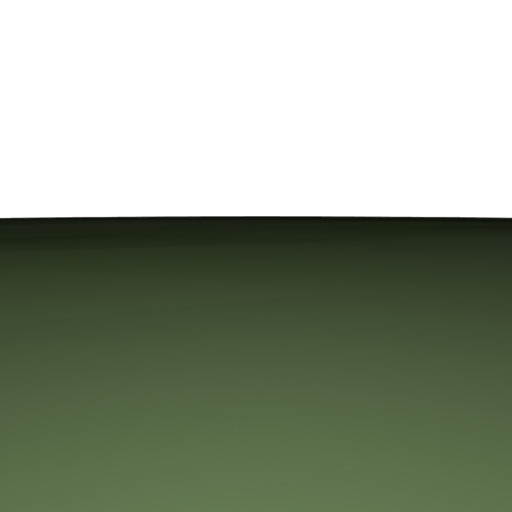

$ ffmpeg -f image2pipe -vcodec png -r 30 -i - -vcodec libx264 -qscale 0 -y /home/thobson2/src/Sunrise-Demo/data/video.mp4


In [65]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Camera:
    position: tuple[float, float, float]
    up: tuple[float, float, float]
    direction: tuple[float, float, float]
        
    def __post_init__(self):
        def unit(v: auto.numpy.typing.ArrayLike):
            v = auto.numpy.asarray(v)
            v = v / auto.numpy.linalg.norm(v)
            return v
        
        unit_up = unit(self.up)
        unit_direction = unit(self.direction)
        assert (dot := auto.numpy.dot(unit_up, unit_direction) < 0.99), \
            f"""Camera up and direction are too similar: {dot=!r}"""
        
@run
def __render():
    def ppargs(args: list, /) -> list:
        print(f'$ {auto.shlex.join(map(str, args))}')
        return args
    
#     auto.subprocess.run(
#         args=ppargs([
#             './go.sh', 'build',
#         ]),
#         stdin=auto.subprocess.DEVNULL,
#         check=True,
#     )

    @contextgenerator
    def renderer():
        with auto.subprocess.Popen(
            args=ppargs([
                './go.sh', 'main',
            ]),
            stdin=auto.subprocess.PIPE,
            stdout=auto.subprocess.PIPE,
            stderr=auto.subprocess.DEVNULL,
        ) as process:
            def write(s: str, /):
    #             print(f'write({s!r})')
                process.stdin.write(s.encode('utf-8'))
                process.stdin.write(b'\n')
                process.stdin.flush()

            def read() -> bytes:
                def read(format, /) -> tuple[Any]:
                    size = auto.struct.calcsize(format)
                    data = process.stdout.read(size)
                    assert len(data) == size, \
                        f"""Didn't read the entire buffer: {len(data)=!r} {size=!r}"""
                    return auto.struct.unpack(format, data)

                count ,= read('N')
    #             print(f'Reading {count} bytes')
                data ,= read(f'{count}s')
                return data

            image = None
            while True:
                camera = yield image
                write('camera')
                write(' '.join(map(str, camera.position)))
                write(' '.join(map(str, camera.up)))
                write(' '.join(map(str, camera.direction)))
                write(' '.join(map(str, (
                    # imageStart
                    0, 0
                ))))
                write(' '.join(map(str, (
                    # imageEnd
                    1, 1
                ))))

                write('render')

                image = read()
    
    def cameras() -> list[Camera]:
        with open(auto.pathlib.Path.cwd() / 'data' / 'Appalachian_Trail.json', 'r') as f:
            trail = auto.json.load(f)
        
#         trail = trail[::8]
        
        cameras = []
        for window in auto.more_itertools.sliding_window(trail, 3 * (k := 4)):
            srcs = window[:k]
            tgts = window[-k:]
            assert len(srcs) == k
            assert len(tgts) == k
            
            src_lat = auto.statistics.fmean(src["lat"] for src in srcs)
            src_lng = auto.statistics.fmean(src["lng"] for src in srcs)
            src_alt: Meter = 2_000 # * auto.random.uniform(0.9, 1.1)

            tgt_lat = auto.statistics.fmean(tgt["lat"] for tgt in tgts)
            tgt_lng = auto.statistics.fmean(tgt["lng"] for tgt in tgts)
            tgt_alt: Meter = 1_500 # * auto.random.uniform(0.9, 1.1)

            src_x, src_y, src_z = map(lambda x: x/1000, convert_location_to_spatial(
                lat=src_lat,
                lng=src_lng,
                alt=src_alt,
            ))

            tgt_x, tgt_y, tgt_z = map(lambda x: x/1000, convert_location_to_spatial(
                lat=tgt_lat,
                lng=tgt_lng,
                alt=tgt_alt,
            ))
            
            cameras.append(Camera(
                position=(
                    src_x,
                    src_y,
                    src_z,
                ),
                up=(
                    src_x,
                    src_y,
                    src_z,
                ),
                direction=(
                    tgt_x - src_x,
                    tgt_y - src_y,
                    tgt_z - src_z,
                ),
            ))
        
        return cameras
    
    @contextgenerator
    def display():
        handle = auto.IPython.display.display(None, display_id=True)
        
        while True:
            obj = yield
            handle.update(obj)
    
    @contextgenerator
    def ffmpeg():
        # Thanks https://stackoverflow.com/a/43871666
        process = None
        
        try:
            process = auto.subprocess.Popen(
                args=ppargs([
                    'ffmpeg',
                    '-f', 'image2pipe',
                    '-vcodec', 'png',
                    '-r', '30',  # FPS
                    '-i', '-',
                    '-vcodec', 'libx264',
                    '-qscale', '0',
                    '-y',  # overwrite
                    auto.pathlib.Path.cwd() / 'data' / 'video.mp4',
                ]),
                stdin=auto.subprocess.PIPE,
                stdout=auto.subprocess.DEVNULL,
                stderr=auto.subprocess.DEVNULL,
            )
            
            while True:
                image = yield

                process.stdin.write(image)
                process.stdin.flush()
        
        finally:
            if process is not None:
                try:
                    process.stdin.close()
                    process.wait(timeout=10)
                    
                except:
                    process.kill()
            
    cameras = cameras()
    with auto.contextlib.ExitStack() as stack:
        renderer = stack.enter_context(renderer())
        display = stack.enter_context(display())
        ffmpeg = stack.enter_context(ffmpeg())
        
        for i, camera in enumerate(cameras):
            image = renderer.send(camera)

            display.send(auto.IPython.display.Image(image, width=512, height=512))
#             display.send(f'{i}')
            ffmpeg.send(image)